In [7]:
import os

if 'google.colab' in str(get_ipython()):
    files = ['util.py',
             'windows.py',
             'models']

    for file in files:
        os.system('rm ./' + file)
        os.system(
            'wget -nv https://raw.githubusercontent.com/marco-mazzoli/progetto-tesi/master/' + file)

import pandas as pd
import numpy as np
import warnings
from matplotlib import pyplot
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.arima_model import ARIMA
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.multioutput import MultiOutputRegressor
from numpy.random import seed

# fix for 'package not found' when installing in Anaconda environment
if 'google.colab' not in str(get_ipython()):
    import pip
    pip.main(['install', 'xgboost'])

import xgboost as xgb
from xgboost import XGBRegressor
from util import select_relevant_rows, select_attributes, read_movement_data, download_updated_mobility_data, download_updated_mobility_data, series_to_supervised, split_dates, save_config, load_config, plot_graphs


In [8]:
use_existing_config = True
column_to_predict = 'terapia_intensiva'
columns = ['nuovi_positivi', 'terapia_intensiva', 'deceduti']
split_percent = 0.75
region_focus = 'Emilia-Romagna'
attribute_focus = 'denominazione_regione'
n_futures = [1, 2, 7, 14]

In [9]:
local_region_path = r'../COVID-19/dati-regioni/dpc-covid19-ita-regioni.csv'
remote_region_path = r'https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv'

regions_frame = pd.read_csv(remote_region_path)

region_focus_data = select_relevant_rows(
    regions_frame,
    attribute_focus,
    region_focus
)

frame_interesting_columns = select_attributes(region_focus_data, [
    'data',
    'ricoverati_con_sintomi',
    'terapia_intensiva',
    'totale_ospedalizzati',
    'variazione_totale_positivi',
    'nuovi_positivi',
    'deceduti',
    'tamponi',
    'ingressi_terapia_intensiva'
])

frame_interesting_columns = pd.DataFrame(frame_interesting_columns)
frame_interesting_columns['data'] = pd.to_datetime(
    frame_interesting_columns['data'])
frame_interesting_columns['data'] = frame_interesting_columns['data'].dt.strftime(
    r'%Y-%m-%d')
frame_interesting_columns = frame_interesting_columns.fillna(0)

mobility_data_url = r'https://www.gstatic.com/covid19/mobility/Global_Mobility_Report.csv'
file_path = r'../Global_Mobility_Report.csv'
mobility_data_zip_url = r'https://www.gstatic.com/covid19/mobility/Region_Mobility_Report_CSVs.zip'
zip_path = r'../Region_Mobility_Report_CSVs.zip'
region_mobility_path = r'../Region_Mobility_Report_CSVs'

download_updated_mobility_data(
    mobility_data_url,
    file_path,
    region_mobility_path,
    mobility_data_zip_url,
    zip_path
)

mobility_df = read_movement_data(
    region_mobility_path,
    'IT_Region_Mobility_Report',
    region='Emilia-Romagna'
)

mobility_df = mobility_df[['date',
                           'retail_and_recreation_percent_change_from_baseline',
                           'grocery_and_pharmacy_percent_change_from_baseline',
                           'parks_percent_change_from_baseline',
                           'transit_stations_percent_change_from_baseline',
                           'workplaces_percent_change_from_baseline',
                           'residential_percent_change_from_baseline']].fillna(0)

frame_interesting_columns.rename(columns={'data': 'date'}, inplace=True)
frame_interesting_columns.set_index('date', inplace=True)
mobility_df.set_index('date', inplace=True)

# revert cumulative data
frame_interesting_columns['deceduti'] = frame_interesting_columns['deceduti'].diff(
)
frame_interesting_columns['tamponi'] = frame_interesting_columns['tamponi'].diff(
)
frame_interesting_columns.dropna(inplace=True)

merged = pd.merge(
    frame_interesting_columns,
    mobility_df,
    on='date'
)

merged = merged.fillna(0)
merged.set_index(pd.DatetimeIndex(merged.index), inplace=True)

# numpy seed
seed(1)

Data already up to date...


In [10]:
def split_series(series, n_past, n_future, arima=False):
    X, y, X_indexes, y_indexes = list(), list(), list(), list()
    index = np.array(series.index).reshape(series.values.shape[0], 1)
    series = series.values

    for window_start in range(len(series)):
        past_end = window_start + n_past
        future_end = past_end + n_future
        if future_end > len(series):
            break
        start = 0 if arima == True else window_start

        past, future = series[start:past_end,
                              :], series[past_end:future_end, :]
        past_index, future_index = index[start:past_end,
                                         :], index[past_end:future_end, :]
        X.append(past)
        y.append(future)
        X_indexes.append(past_index)
        y_indexes.append(future_index)

    return np.array(X), np.array(y), np.array(X_indexes), np.array(y_indexes)

#LSTM Multi Output 

Best Config
{'input': 64, 'hidden': 64, 'activation': 'relu', 'dropout': 0.1, 'out': 1, 'optimizer': 'adam', 'loss': 'mae', 'look_back': 28}
('Best MAE: ', 0.8547515869141193)
('Average MAE: ', 107.31327608205976)


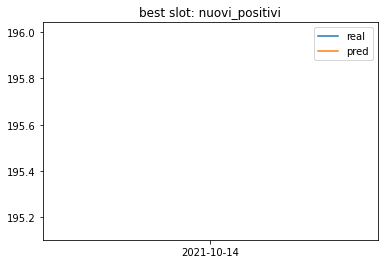

Best Config
{'input': 32, 'hidden': 64, 'activation': 'relu', 'dropout': 0.1, 'out': 1, 'optimizer': 'adam', 'loss': 'mae', 'look_back': 28}
('Best MAE: ', 5.030242919921868)
('Average MAE: ', 14.963101738560809)


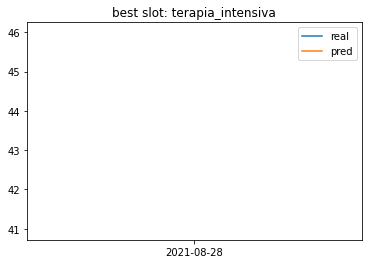

Best Config
{'input': 128, 'hidden': 64, 'activation': 'relu', 'dropout': 0.2, 'out': 1, 'optimizer': 'adam', 'loss': 'mae', 'look_back': 28}
('Best MAE: ', 0.007217407226563388)
('Average MAE: ', 3.4345758848816823)


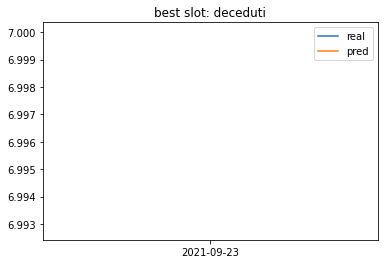

Best Config
{'input': 128, 'hidden': 32, 'activation': 'relu', 'dropout': 0.1, 'out': 1, 'optimizer': 'adam', 'loss': 'mae', 'look_back': 28}
('Best MAE: ', 12.623168945312443)
('Average MAE: ', 108.80891306260052)


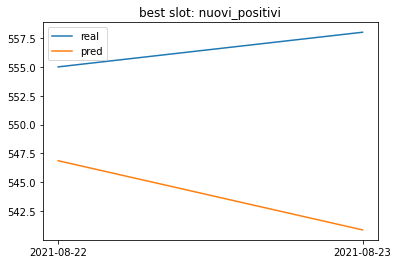

Best Config
{'input': 64, 'hidden': 64, 'activation': 'relu', 'dropout': 0.1, 'out': 1, 'optimizer': 'adam', 'loss': 'mae', 'look_back': 28}
('Best MAE: ', 7.278341293334957)
('Average MAE: ', 16.229966155308134)


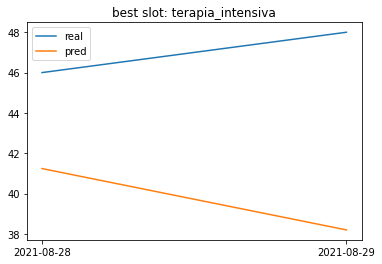

Best Config
{'input': 32, 'hidden': 64, 'activation': 'relu', 'dropout': 0.2, 'out': 1, 'optimizer': 'adam', 'loss': 'mae', 'look_back': 28}
('Best MAE: ', 4.117355346679686)
('Average MAE: ', 11.041989035466138)


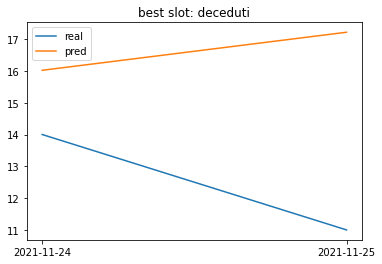

Best Config
{'input': 128, 'hidden': 128, 'activation': 'relu', 'dropout': 0.1, 'out': 1, 'optimizer': 'adam', 'loss': 'mae', 'look_back': 28}
('Best MAE: ', 33.75263759068079)
('Average MAE: ', 116.03011672291395)


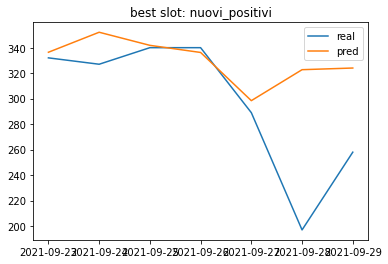

Best Config
{'input': 32, 'hidden': 64, 'activation': 'relu', 'dropout': 0.1, 'out': 1, 'optimizer': 'adam', 'loss': 'mae', 'look_back': 28}
('Best MAE: ', 1.404277801513673)
('Average MAE: ', 6.4519904021218375)


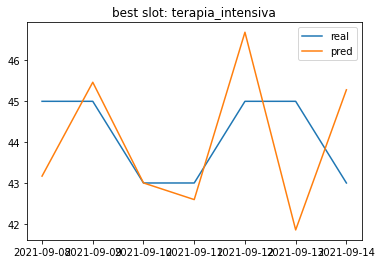

Best Config
{'input': 32, 'hidden': 64, 'activation': 'relu', 'dropout': 0.1, 'out': 1, 'optimizer': 'adam', 'loss': 'mae', 'look_back': 28}
('Best MAE: ', 1.540223326001849)
('Average MAE: ', 3.2589467346603254)


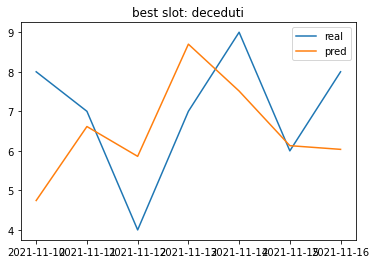

Best Config
{'input': 32, 'hidden': 128, 'activation': 'relu', 'dropout': 0.2, 'out': 1, 'optimizer': 'adam', 'loss': 'mae', 'look_back': 28}
('Best MAE: ', 48.90819440569196)
('Average MAE: ', 166.86035281062672)


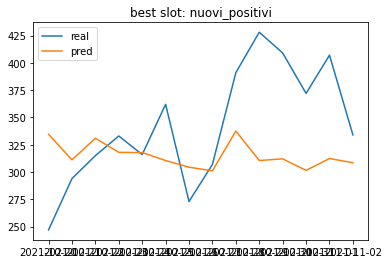

Best Config
{'input': 128, 'hidden': 128, 'activation': 'relu', 'dropout': 0.2, 'out': 1, 'optimizer': 'adam', 'loss': 'mae', 'look_back': 28}
('Best MAE: ', 1.9410939897809723)
('Average MAE: ', 11.72202940250871)


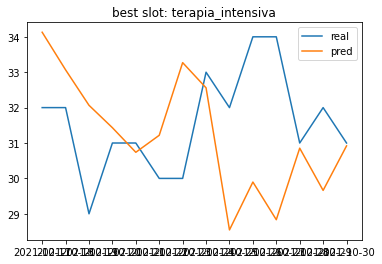

Best Config
{'input': 64, 'hidden': 128, 'activation': 'relu', 'dropout': 0.2, 'out': 1, 'optimizer': 'adam', 'loss': 'mae', 'look_back': 28}
('Best MAE: ', 1.788206236703055)
('Average MAE: ', 3.2927875991241184)


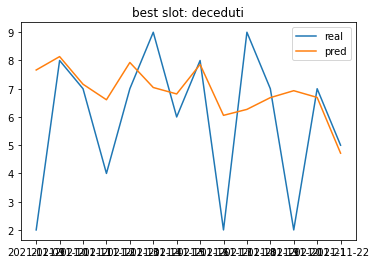

In [11]:
def define_compile_lstm(config, input_shape, n_future=7):
    model = Sequential()
    model.add(LSTM(config['input'], activation=config['activation'],
                   input_shape=input_shape, return_sequences=True))
    model.add(LSTM(config['hidden'], activation=config['activation'],
                   return_sequences=False))
    model.add(Dropout(config['dropout']))
    model.add(Dense(n_future))
    model.compile(optimizer=config['optimizer'], loss=config['loss'])
    return model


def define_lstm_configs():
    input = [32, 64, 128]
    hidden = [32, 64, 128]
    activation = ['relu']
    dropout = [0.1, 0.2]
    out = [1]
    optimizer = ['adam']
    loss = ['mae']
    look_back = [28]

    configs = []
    keys = ['input', 'hidden', 'activation', 'dropout', 'out',
            'optimizer', 'loss', 'look_back']

    for i in input:
        for j in hidden:
            for k in activation:
                for l in dropout:
                    for m in out:
                        for n in optimizer:
                            for o in loss:
                                for p in look_back:
                                        config = dict(
                                            zip(keys, (i, j, k, l, m, n, o, p)))
                                        configs.append(config)

    return configs


def execute_lstm(
        dataframe, column_to_predict, config, split_percent=0.80, multi=False, n_future=7):
    df = dataframe[column_to_predict].copy()

    split = int(split_percent*len(df))

    n_past = config['look_back']
    n_features = 1

    train, test = pd.DataFrame(df[:split]), pd.DataFrame(df[split:])

    scalers = {}

    for i in train.columns:
        scaler = MinMaxScaler(feature_range=(-1, 1))
        s_s = scaler.fit_transform(train[i].values.reshape(-1, 1))
        s_s = np.reshape(s_s, len(s_s))
        scalers['scaler_' + i] = scaler
        train[i] = s_s

    for i in test.columns:
        scaler = scalers['scaler_'+i]
        s_s = scaler.transform(test[i].values.reshape(-1, 1))
        s_s = np.reshape(s_s, len(s_s))
        scalers['scaler_'+i] = scaler
        test[i] = s_s

    X_train, y_train, X_train_indexes, y_train_indexes = split_series(
        train, n_past, n_future)
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
    y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))

    X_test, y_test, X_test_indexes, y_test_indexes = split_series(
        test, n_past, n_future)
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))
    y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], n_features))

    model = define_compile_lstm(config, input_shape=(n_past,n_features), n_future=n_future)

    history = model.fit(
        X_train, y_train, epochs=50, validation_data=(X_test, y_test),
        verbose=0, shuffle=False)

    pred = model.predict(X_test)

    pred = pred.reshape(pred.shape[0], pred.shape[1], 1)

    for index, i in enumerate(train.columns):
        scaler = scalers['scaler_'+i]

        pred[:, :, index] = scaler.inverse_transform(pred[:, :, index])

        y_train[:, :, index] = scaler.inverse_transform(y_train[:, :, index])
        y_test[:, :, index] = scaler.inverse_transform(y_test[:, :, index])

    df_results = []

    for i in range(len(y_test)):
        current = pd.DataFrame(
            {'y_test':y_test[i].reshape(-1),
            'pred':pred[i].reshape(-1),
            'dates':y_test_indexes[i].reshape(-1)})
        current.set_index('dates', inplace=True)
        df_results.append(current)

    results = {}

    for el in df_results:
        error = mean_absolute_error(el['y_test'], el['pred'])
        results[el.index[0]] = (error, el)

    sorted_results = sorted(results.items(), key=lambda x: x[1][0])

    return sorted_results


def grid_search_lstm(
        dataframe, column_to_predict, split_percent=0.80, multi=False, n_future=7):
    configs = define_lstm_configs()
    results = []

    for config in configs:
        sorted_results = execute_lstm(
            dataframe, column_to_predict, config, split_percent=split_percent,
            multi=multi, n_future=n_future)

        results.append((np.mean(np.array(list(map(lambda x:x[1][0], sorted_results)))), config))

    return results


for n_future in n_futures:
    for column_to_predict in columns:
        config_path = region_focus + '_' + 'uni_lstm_config' + '_' + column_to_predict
        config_path = config_path + '_' + str(n_future)
        if use_existing_config:
            if not os.path.isfile(config_path):
                os.system('wget -nv https://raw.githubusercontent.com/marco-mazzoli/progetto-tesi/master/configs/' + config_path)
            config = load_config(config_path)
            sorted_results = execute_lstm(
                frame_interesting_columns, column_to_predict=column_to_predict,
                config=config, split_percent=split_percent, multi=False, n_future=n_future)
            os.system('rm ' + config_path)
        else:
            results = grid_search_lstm(
                frame_interesting_columns, column_to_predict, split_percent=split_percent,
                multi=False, n_future=n_future)

            results.sort()
            config = results[0][-1]

            save_config(config_path, config)

            sorted_results = execute_lstm(
                frame_interesting_columns, column_to_predict=column_to_predict,
                config=config, split_percent=split_percent, multi=False, n_future=n_future)

        print('Best Config')
        print(config)

        print(('Best MAE: ', sorted_results[0][1][0]))
        print(('Average MAE: ', np.mean(np.array(list(map(lambda x:x[1][0], sorted_results))))))
        pyplot.plot(sorted_results[0][1][1]['y_test'])
        pyplot.plot(sorted_results[0][1][1]['pred'])
        pyplot.title('best slot: ' + column_to_predict)
        pyplot.legend(['real', 'pred'])
        pyplot.show()


#XGBoost Multi Output

Best Config
{'max_depth': 3, 'learning_rate': 0.05, 'n_estimators': 100, 'colsample_bytree': 0.7, 'look_back': 28, 'objective': 'reg:squarederror'}
('Best MAE: ', 1.334991455078125)
('Average MAE: ', 76.7220563679716)


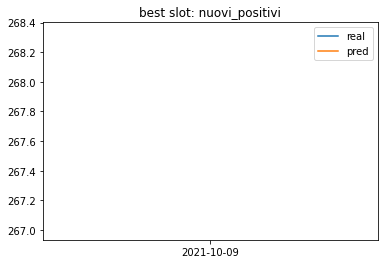

Best Config
{'max_depth': 10, 'learning_rate': 0.05, 'n_estimators': 500, 'colsample_bytree': 0.7, 'look_back': 28, 'objective': 'reg:squarederror'}
('Best MAE: ', 0.1687469482422017)
('Average MAE: ', 3.233132049115034)


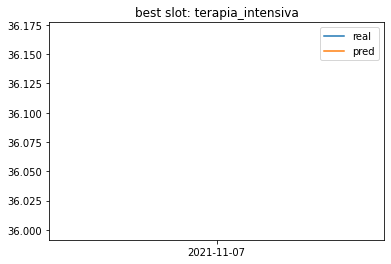

Best Config
{'max_depth': 3, 'learning_rate': 0.01, 'n_estimators': 500, 'colsample_bytree': 0.3, 'look_back': 28, 'objective': 'reg:squarederror'}
('Best MAE: ', 0.01028084754944203)
('Average MAE: ', 3.1965339292574972)


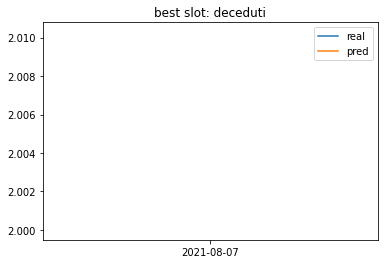

Best Config
{'max_depth': 3, 'learning_rate': 0.05, 'n_estimators': 100, 'colsample_bytree': 0.7, 'look_back': 28, 'objective': 'reg:squarederror'}
('Best MAE: ', 1.999053955078125)
('Average MAE: ', 84.78330320470474)


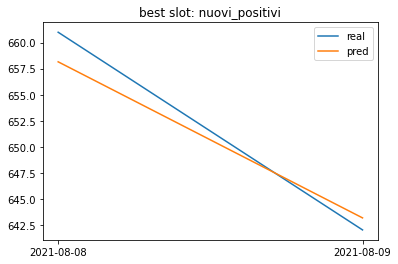

Best Config
{'max_depth': 10, 'learning_rate': 0.05, 'n_estimators': 500, 'colsample_bytree': 0.7, 'look_back': 28, 'objective': 'reg:squarederror'}
('Best MAE: ', 0.36508941650390625)
('Average MAE: ', 3.657332956790923)


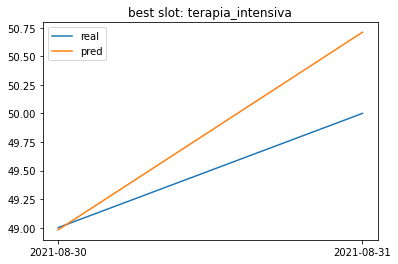

Best Config
{'max_depth': 3, 'learning_rate': 0.01, 'n_estimators': 500, 'colsample_bytree': 0.3, 'look_back': 28, 'objective': 'reg:squarederror'}
('Best MAE: ', 0.23650056123733565)
('Average MAE: ', 3.2389294281601906)


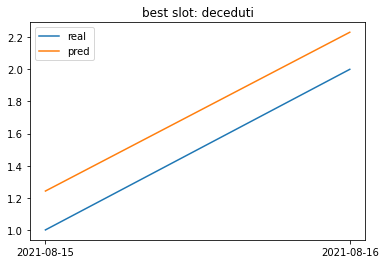

Best Config
{'max_depth': 3, 'learning_rate': 0.05, 'n_estimators': 100, 'colsample_bytree': 0.7, 'look_back': 28, 'objective': 'reg:squarederror'}
('Best MAE: ', 27.408519199916295)
('Average MAE: ', 100.04238142806025)


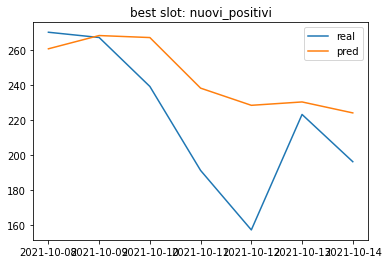

Best Config
{'max_depth': 10, 'learning_rate': 0.05, 'n_estimators': 500, 'colsample_bytree': 0.7, 'look_back': 28, 'objective': 'reg:squarederror'}
('Best MAE: ', 1.4299261910574772)
('Average MAE: ', 5.027760468236492)


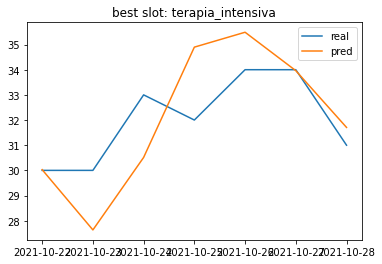

Best Config
{'max_depth': 3, 'learning_rate': 0.01, 'n_estimators': 500, 'colsample_bytree': 0.3, 'look_back': 28, 'objective': 'reg:squarederror'}
('Best MAE: ', 1.1270717382431037)
('Average MAE: ', 3.46891586139652)


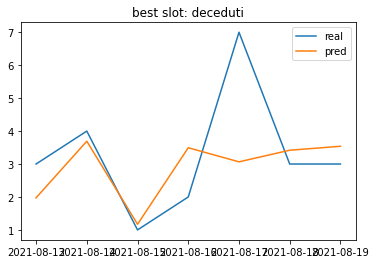

Best Config
{'max_depth': 3, 'learning_rate': 0.05, 'n_estimators': 100, 'colsample_bytree': 0.7, 'look_back': 28, 'objective': 'reg:squarederror'}
('Best MAE: ', 36.30163138253346)
('Average MAE: ', 143.54710854473203)


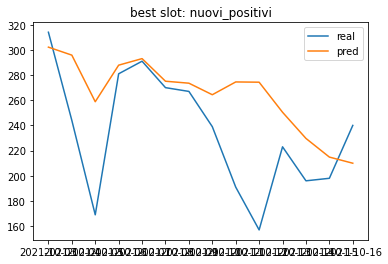

Best Config
{'max_depth': 10, 'learning_rate': 0.05, 'n_estimators': 500, 'colsample_bytree': 0.7, 'look_back': 28, 'objective': 'reg:squarederror'}
('Best MAE: ', 2.121785981314522)
('Average MAE: ', 8.503126962943009)


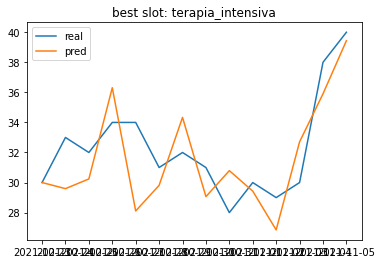

Best Config
{'max_depth': 3, 'learning_rate': 0.01, 'n_estimators': 500, 'colsample_bytree': 0.3, 'look_back': 28, 'objective': 'reg:squarederror'}
('Best MAE: ', 1.8785280329840526)
('Average MAE: ', 4.037712797453876)


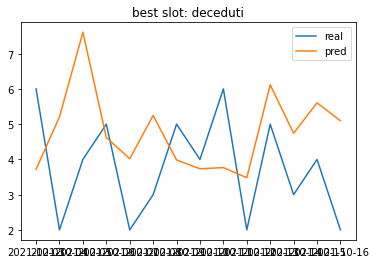

In [12]:
def define_xgb_configs():
    max_depth = [3, 6, 10]
    learning_rate = [0.01, 0.05, 0.1]
    n_estimators = [50, 100, 500, 1000]
    colsample_bytree = [0.3, 0.7]
    look_back = [28]
    objectives = ['reg:squarederror']

    configs = []
    keys = ['max_depth', 'learning_rate', 'n_estimators', 'colsample_bytree',
            'look_back', 'objective']

    for i in max_depth:
        for j in learning_rate:
            for k in n_estimators:
                for l in colsample_bytree:
                    for m in look_back:
                            for n in objectives:
                                config = dict(
                                    zip(keys, (i, j, k, l, m, n)))
                            configs.append(config)

    return configs


def execute_xgb(
        dataframe, column_to_predict, config, split_percent=0.80, n_future=7, multi=False):
    df = dataframe[column_to_predict].copy()
    split = int(split_percent*len(df))

    n_past = config['look_back']
    n_features = 1

    train, test = pd.DataFrame(df[:split]), pd.DataFrame(df[split:])

    scalers = {}

    for i in train.columns:
        scaler = MinMaxScaler(feature_range=(-1, 1))
        s_s = scaler.fit_transform(train[i].values.reshape(-1, 1))
        s_s = np.reshape(s_s, len(s_s))
        scalers['scaler_' + i] = scaler
        train[i] = s_s

    for i in test.columns:
        scaler = scalers['scaler_'+i]
        s_s = scaler.transform(test[i].values.reshape(-1, 1))
        s_s = np.reshape(s_s, len(s_s))
        scalers['scaler_'+i] = scaler
        test[i] = s_s

    X_train, y_train, X_train_indexes, y_train_indexes = split_series(
        train, n_past, n_future)

    X_test, y_test, X_test_indexes, y_test_indexes = split_series(
        test, n_past, n_future)

    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])
    y_train = y_train.reshape(y_train.shape[0], y_train.shape[1])
    X_train_indexes = X_train_indexes.reshape(
        X_train_indexes.shape[0], X_train_indexes.shape[1])
    y_train_indexes = y_train_indexes.reshape(
        y_train_indexes.shape[0], y_train_indexes.shape[1])

    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1])
    y_test = y_test.reshape(y_test.shape[0], y_test.shape[1])
    X_test_indexes = X_test_indexes.reshape(
        X_test_indexes.shape[0], X_test_indexes.shape[1])
    y_test_indexes = y_test_indexes.reshape(
        y_test_indexes.shape[0], y_test_indexes.shape[1])

    model = define_xgb(config)
    warnings.filterwarnings(action='ignore', category=UserWarning)
    model.fit(X_train, y_train)

    prediction = model.predict(X_test)  

    prediction[:, :] = scaler.inverse_transform(prediction[:, :])
    y_test[:, :] = scaler.inverse_transform(y_test[:, :])

    df_results = []

    for i in range(len(y_test)):
        current = pd.DataFrame(
            {'y_test':y_test[i].reshape(-1),
            'pred':prediction[i].reshape(-1),
            'dates':y_test_indexes[i].reshape(-1)})
        current.set_index('dates', inplace=True)
        df_results.append(current)

    results = {}

    for el in df_results:
        error = mean_absolute_error(el['y_test'], el['pred'])
        results[el.index[0]] = (error, el)

    sorted_results = sorted(results.items(), key=lambda x: x[1][0])

    return sorted_results


def grid_search_xgb(
        dataframe, column_to_predict, split_percent=0.80, n_future=7, multi=False):
    configs = define_xgb_configs()
    results = []

    for config in configs:
        sorted_results = execute_xgb(
            dataframe, column_to_predict, config, split_percent=split_percent,
            multi=multi, n_future=n_future)

        results.append((np.mean(np.array(list(map(lambda x:x[1][0], sorted_results)))), config))

    return results


def define_xgb(config):
    return MultiOutputRegressor(XGBRegressor(**config, verbosity=0))


for n_future in n_futures:
    for column_to_predict in columns:
        config_path = region_focus + '_' + 'uni_xgb_config' + '_' + column_to_predict
        config_path = config_path + '_' + str(n_future)
        if use_existing_config:
            if not os.path.isfile(config_path):
                os.system('wget -nv https://raw.githubusercontent.com/marco-mazzoli/progetto-tesi/master/configs/' + config_path)
            config = load_config(config_path)
            sorted_results = execute_xgb(
                frame_interesting_columns, split_percent=split_percent, config=config,
                column_to_predict=column_to_predict, multi=False, n_future=n_future)
            os.system('rm ' + config_path)
        else:
            results = grid_search_xgb(
                frame_interesting_columns, split_percent=split_percent,
                column_to_predict=column_to_predict, multi=False)

            results.sort(key=lambda tup: tup[0])

            config = results[0][-1]

            save_config(config_path, config)

            sorted_results = execute_xgb(
                frame_interesting_columns, split_percent=split_percent, config=config,
                column_to_predict=column_to_predict, multi=False, n_future=n_future)

        print('Best Config')
        print(config)

        print(('Best MAE: ', sorted_results[0][1][0]))
        print(('Average MAE: ', np.mean(
            np.array(list(map(lambda x:x[1][0], sorted_results))))))
        pyplot.plot(sorted_results[0][1][1]['y_test'])
        pyplot.plot(sorted_results[0][1][1]['pred'])
        pyplot.title('best slot: ' + column_to_predict)
        pyplot.legend(['real', 'pred'])
        pyplot.show()


#ARIMA Multi Output

Best Config
(10, 1, 1)
('Best MAE: ', 30.79029567737848)
('Average MAE: ', 97.0084558031317)


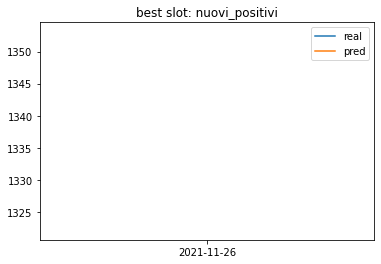

Best Config
(10, 1, 1)
('Best MAE: ', 0.3268514386343213)
('Average MAE: ', 3.108952225290301)


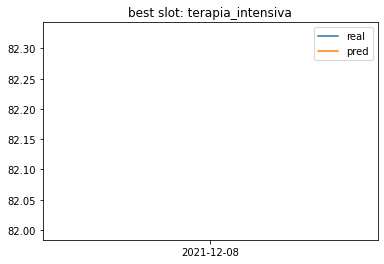

Best Config
(10, 1, 1)
('Best MAE: ', 0.029646112358207688)
('Average MAE: ', 3.1702967696320967)


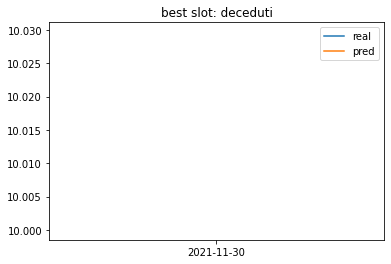

Best Config
(10, 1, 1)
('Best MAE: ', 34.15966372221567)
('Average MAE: ', 103.56016952225269)


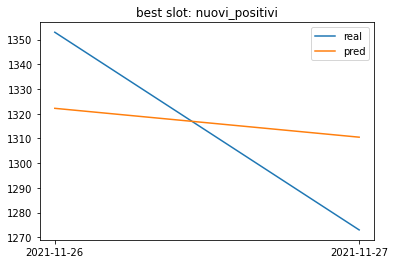

Best Config
(10, 1, 1)
('Best MAE: ', 0.4025556897722353)
('Average MAE: ', 4.012384104029207)


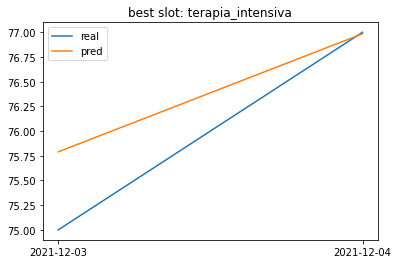

Best Config
(10, 1, 1)
('Best MAE: ', 0.4466072700981334)
('Average MAE: ', 3.1020025589854416)


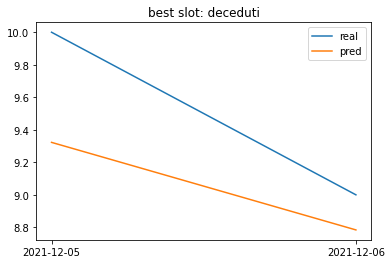

Best Config
(10, 1, 1)
('Best MAE: ', 53.938684749484345)
('Average MAE: ', 102.1445683998954)


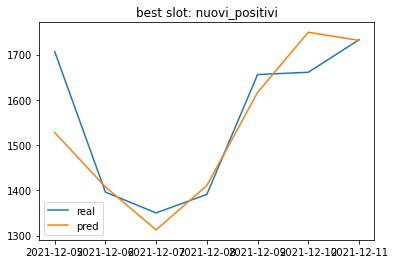

Best Config
(10, 1, 1)
('Best MAE: ', 1.979817269870797)
('Average MAE: ', 5.855810110442318)


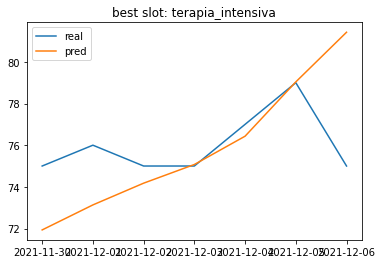

Best Config
(10, 1, 1)
('Best MAE: ', 2.1403810650156667)
('Average MAE: ', 2.9821021449281835)


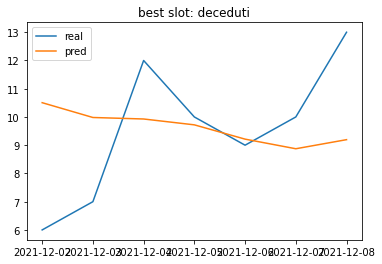

Best Config
(10, 1, 1)
('Best MAE: ', 82.73406374561542)
('Average MAE: ', 108.31135902114563)


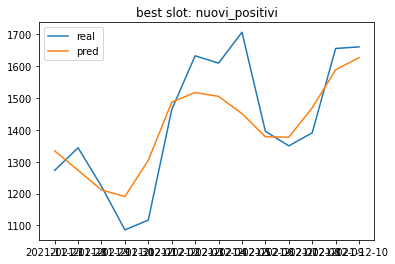

Best Config
(10, 1, 1)
('Best MAE: ', 2.275773470597851)
('Average MAE: ', 9.302967122800217)


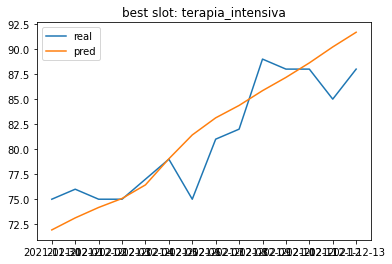

Best Config
(10, 1, 1)
('Best MAE: ', 2.5083107166358607)
('Average MAE: ', 2.941421189195827)


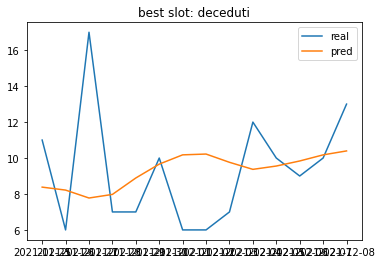

In [13]:
split_percent = 0.95

def execute_arima(dataframe, order, column_to_predict, split_percent, n_future=7):
    df = dataframe[column_to_predict].copy()
    split = int(split_percent*len(df))

    n_past = 14
    n_features = 1

    train, test = pd.DataFrame(df[:split]), pd.DataFrame(df[split:])

    scalers = {}

    for i in train.columns:
        scaler = MinMaxScaler(feature_range=(-1, 1))
        s_s = scaler.fit_transform(train[i].values.reshape(-1, 1))
        s_s = np.reshape(s_s, len(s_s))
        scalers['scaler_' + i] = scaler
        train[i] = s_s

    for i in test.columns:
        scaler = scalers['scaler_'+i]
        s_s = scaler.transform(test[i].values.reshape(-1, 1))
        s_s = np.reshape(s_s, len(s_s))
        scalers['scaler_'+i] = scaler
        test[i] = s_s

    X_train, y_train, X_train_indexes, y_train_indexes = split_series(
        train, n_past, n_future, arima=True)

    X_test, y_test, X_test_indexes, y_test_indexes = split_series(
        test, n_past, n_future, arima=True)
    
    df_results = []

    history = [x for x in train.values]

    for i in range(len(X_test)):
        current_history = np.array(history).reshape(-1)
        current_history = np.append(current_history, X_test[i].reshape(-1))

        model = ARIMA(current_history, order=order)
        model_fitted = model.fit()
        prediction = model_fitted.forecast(n_future)[0]

        prediction = scaler.inverse_transform(prediction.reshape(-1,1))
        y_test[i] = scaler.inverse_transform(y_test[i])

        current = pd.DataFrame(
            {'y_test':y_test[i].reshape(-1),
            'pred':prediction.reshape(-1),
            'dates':y_test_indexes[i].reshape(-1)})

        current.set_index('dates', inplace=True)
        
        df_results.append(current)

    results = {}

    for el in df_results:
        error = mean_absolute_error(el['y_test'], el['pred'])
        results[el.index[0]] = (error, el)

    sorted_results = sorted(results.items(), key=lambda x: x[1][0])

    return sorted_results


def define_arima_configs():
    p_values = [10]
    d_values = [1]
    q_values = [1]
    return p_values, d_values, q_values


def evaluate_models(dataframe, column_to_predict, split_percent, n_future=7):
    p_values, d_values, q_values = define_arima_configs()
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p, d, q)
                sorted_results = execute_arima(
                    dataframe, order, column_to_predict, split_percent, n_future)
                avg_error = np.mean(
                    np.array(list(map(lambda x:x[1][0], sorted_results))))
                if avg_error < best_score:
                    best_score, best_cfg = avg_error, order
    return best_cfg


for n_future in n_futures:
    for column_to_predict in columns:
        config_path = region_focus + '_' + 'arima_config' + '_' + column_to_predict
        config_path = config_path + '_' + str(n_future)
        if use_existing_config:
            if not os.path.isfile(config_path):
                os.system('wget -nv https://raw.githubusercontent.com/marco-mazzoli/progetto-tesi/master/configs/' + config_path)
            config = load_config(config_path)
            sorted_results = execute_arima(
                frame_interesting_columns, config, column_to_predict, split_percent, n_future=n_future)
            os.system('rm ' + config_path)
        else:
            config = evaluate_models(
                frame_interesting_columns, column_to_predict, split_percent)

            save_config(config_path, config)

            sorted_results = execute_arima(
                frame_interesting_columns, config, column_to_predict, split_percent, n_future=n_future)

        print('Best Config')
        print(config)

        print(('Best MAE: ', sorted_results[0][1][0]))
        print(('Average MAE: ', np.mean(
            np.array(list(map(lambda x:x[1][0], sorted_results))))))
        pyplot.plot(sorted_results[0][1][1]['y_test'])
        pyplot.plot(sorted_results[0][1][1]['pred'])
        pyplot.title('best slot: ' + column_to_predict)
        pyplot.legend(['real', 'pred'])
        pyplot.show()
